# image controller

test list
2134
2198

In [1]:
box = (640,417,537,255)  


In [1]:
from my_tools.control import ImageController
controller = ImageController()

no function apply using default function


In [2]:
controller.run()

# model test


640-1280 is good
1449.jpg

In [2]:
from PIL import Image
import matplotlib.pyplot as plt
import numpy as np

In [3]:
import torch
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [3]:
# # Load model directly
# from transformers import AutoImageProcessor, SegformerForSemanticSegmentation

# processor = AutoImageProcessor.from_pretrained("nvidia/segformer-b0-finetuned-cityscapes-640-1280",return_tensors="pt")
# model = SegformerForSemanticSegmentation.from_pretrained("nvidia/segformer-b0-finetuned-cityscapes-640-1280")

## segformer hugging face

In [10]:
# custom preprocess
from torchvision import transforms

mean = [0.485, 0.456, 0.406]
std = [0.229, 0.224, 0.225]

custom_process = transforms.Compose([

    transforms.ToTensor(),
    # transforms.Resize((512,1024)),
    transforms.Normalize(mean = mean,std= std)

])


In [1]:
from seg.seg_utils import HF_segFormermodel

# model_repo = "nvidia/segformer-b0-finetuned-cityscapes-768-768"
# model_repo = "nvidia/segformer-b0-finetuned-cityscapes-512-1024"
# model_repo = "nvidia/segformer-b0-finetuned-cityscapes-640-1280"
model_repo = "nvidia/segformer-b1-finetuned-cityscapes-1024-1024"


# seg_model = HF_segFormermodel(model_repo,custom_processor=custom_process)
seg_model = HF_segFormermodel(model_repo)

/home/lpr/miniconda3/envs/CarlaEnv/lib/python3.8/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


using  cuda


/home/lpr/miniconda3/envs/CarlaEnv/lib/python3.8/site-packages/transformers/models/segformer/image_processing_segformer.py:103: FutureWarning: The `reduce_labels` parameter is deprecated and will be removed in a future version. Please use `do_reduce_labels` instead.
  warnings.warn(


inference time :0.09


In [4]:
import cv2
def seg_wraper(img,crop_box):
    y1,y2, x1,x2 = crop_box
    img = img[y1:y2, x1:x2]
    img = cv2.cvtColor(img,cv2.COLOR_BGR2RGB)
    preds, _ = seg_model.predict([img],upsampling=True)
    # raise Exception("hi")

    # segs = seg_model.get_seg_image(preds)
    
    # return segs

    overlays = seg_model.get_seg_overlay([img],preds) 
    return overlays

# controller.apply_processor(seg_wraper)
controller.process = seg_wraper

In [5]:
controller.run()

In [17]:
import cv2

img1 = cv2.imread("data/raw_4cams/front/3800.jpg")
img2 = cv2.imread("data/raw_4cams/left/1380.jpg")
img3 = cv2.imread("data/raw_4cams/right/1000.jpg")

In [20]:

img1 = cv2.cvtColor(img1,cv2.COLOR_BGR2RGB)
preds, _ = seg_model.predict([img1],upsampling=True)
# raise Exception("hi")

# segs = seg_model.get_seg_image(preds)

# return segs

overlays = seg_model.get_seg_overlay([img1],preds) 


In [12]:
img1.shape

(720, 1280, 3)

In [24]:
list_tensor = [test_transform(im) for im in [img1,img2,img3]]


In [25]:
batch_tensor = torch.stack(list_tensor, dim=0)

In [26]:
batch_tensor.shape

torch.Size([3, 3, 1024, 512])

In [32]:
batch_tensor = batch_tensor.to(device)

In [10]:
inputs = seg_model.processor([img1,img2,img3],return_tensors="pt")["pixel_values"].to(device)

In [10]:
inputs.shape

torch.Size([3, 3, 512, 512])

In [12]:
with torch.no_grad():

    logits = seg_model.model(pixel_values = inputs).logits

In [13]:
logits.shape

torch.Size([3, 19, 128, 128])

In [15]:
pred = logits.argmax(dim=1).cpu()
pred.shape

torch.Size([3, 128, 128])

In [21]:
img = cv2.resize(img1,(pred[0].shape[0],pred[0].shape[1]))

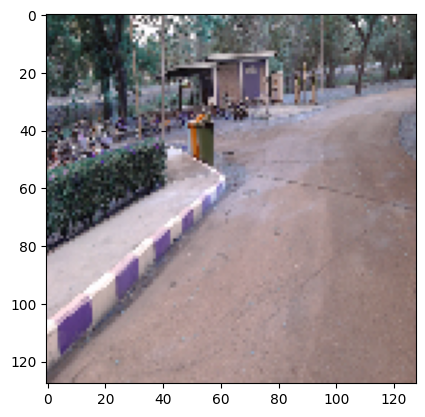

In [22]:
plt.imshow(img)

In [20]:
from torch import nn
upsampled_logits = nn.functional.interpolate(
    logits,
    size=img1.shape[:-1], # (height, width)
    mode='bilinear',
    align_corners=False
)

In [25]:
upsampled_logits.shape

torch.Size([3, 19, 720, 1280])

In [21]:
pred = upsampled_logits.argmax(dim=1).cpu()

In [23]:
pred[0].shape

torch.Size([720, 1280])

In [ ]:
def sidewalk_palette():
        """Sidewalk palette that maps each class to RGB values."""
        return [
            [155, 155, 155],
            [216, 82, 24],
            [255, 255, 0],
            [125, 46, 141],
            [118, 171, 47],
            [161, 19, 46],
            [255, 0, 0],
            [0, 128, 128],
            [190, 190, 0],
            [0, 255, 0],
            [0, 0, 255],
            [170, 0, 255],
            [84, 84, 0],
            [84, 170, 0],
            [84, 255, 0],
            [170, 84, 0],
            [170, 170, 0],
            [170, 255, 0],
            [255, 84, 0],
            [255, 170, 0],
            [255, 255, 0],
            [33, 138, 200],
            [0, 170, 127],
            [0, 255, 127],
            [84, 0, 127],
            [84, 84, 127],
            [84, 170, 127],
            [84, 255, 127],
            [170, 0, 127],
            [170, 84, 127],
            [170, 170, 127],
            [170, 255, 127],
            [255, 0, 127],
            [255, 84, 127],
            [255, 170, 127],
        ]

def get_seg_overlay(images, segs):
    imgs=[]
    for i in range(len(images)):
        color_seg = np.zeros((segs[i].shape[0], segs[i].shape[1], 3), dtype=np.uint8) # height, width, 3
        palette = np.array(sidewalk_palette())
        for label, color in enumerate(palette):
            color_seg[segs[i] == label, :] = color

        # Show image + mask
        img = np.array(images[i]) * 0.5 + color_seg * 0.5
        imgs.append(img.astype(np.uint8))

    return imgs

In [43]:
overlays = get_seg_overlay([img1,img2,img3],pred)

In [45]:
import cv2 
for i,overlay in enumerate(overlays):
    name = f"test{i}"
    cv2.imshow(name,overlay)

cv2.waitKey(0)
cv2.destroyAllWindows()

In [14]:
batch_tensor = np.stack([img1,img2,img3], axis=0)

In [16]:
batch_tensor.shape

(3, 720, 1280, 3)

In [ ]:
seg,overlay,logits = seg_model.predict(batch_tensor)

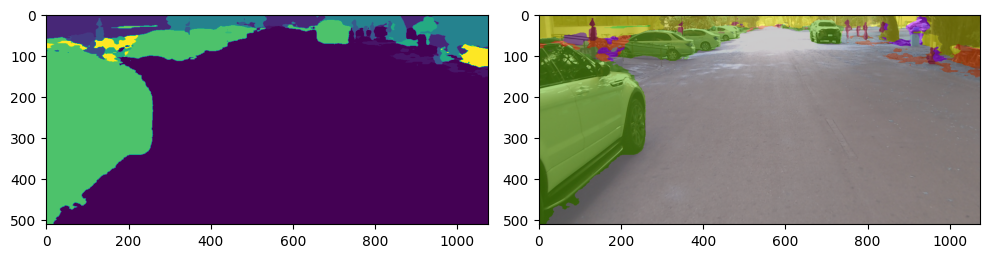

In [21]:
import matplotlib.pyplot as plt
fig,ax = plt.subplots(1,2,figsize=(10, 30))
ax[0].imshow(pred)
ax[1].imshow(overlayed)

plt.tight_layout()  # Optional: Adjust subplot parameters to give specified padding
plt.show()


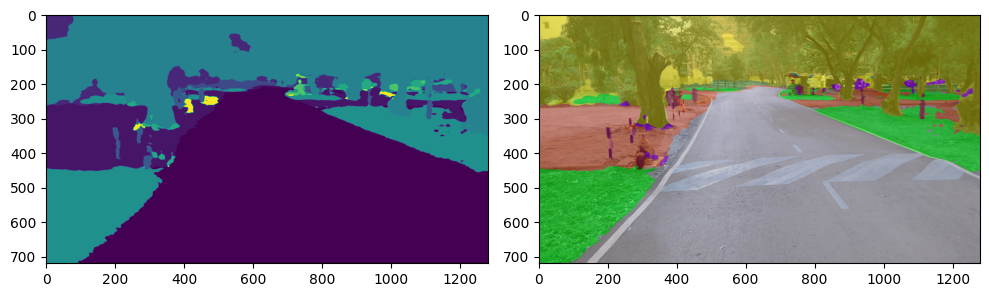

In [9]:
import matplotlib.pyplot as plt
fig,ax = plt.subplots(1,2,figsize=(10, 30))
ax[0].imshow(pred)
ax[1].imshow(overlayed)

plt.tight_layout()  # Optional: Adjust subplot parameters to give specified padding
plt.show()


## mask2former hugging face

In [8]:
import requests
import torch
from PIL import Image
import matplotlib.pyplot as plt
import numpy as np
from transformers import AutoImageProcessor, Mask2FormerForUniversalSegmentation

# Load Mask2Former model and image processor
repo = "facebook/mask2former-swin-large-mapillary-vistas-semantic"
processor = AutoImageProcessor.from_pretrained(repo)
model = Mask2FormerForUniversalSegmentation.from_pretrained(repo)
model.to(device)


Mask2FormerForUniversalSegmentation(
  (model): Mask2FormerModel(
    (pixel_level_module): Mask2FormerPixelLevelModule(
      (encoder): SwinBackbone(
        (embeddings): SwinEmbeddings(
          (patch_embeddings): SwinPatchEmbeddings(
            (projection): Conv2d(3, 192, kernel_size=(4, 4), stride=(4, 4))
          )
          (norm): LayerNorm((192,), eps=1e-05, elementwise_affine=True)
          (dropout): Dropout(p=0.0, inplace=False)
        )
        (encoder): SwinEncoder(
          (layers): ModuleList(
            (0): SwinStage(
              (blocks): ModuleList(
                (0-1): 2 x SwinLayer(
                  (layernorm_before): LayerNorm((192,), eps=1e-05, elementwise_affine=True)
                  (attention): SwinAttention(
                    (self): SwinSelfAttention(
                      (query): Linear(in_features=192, out_features=192, bias=True)
                      (key): Linear(in_features=192, out_features=192, bias=True)
                     

In [9]:
import cv2

img1 = cv2.imread("data/raw_4cams/front/263.jpg")
img2 = cv2.imread("data/raw_4cams/front/3248.jpg")
img3 = cv2.imread("data/raw_4cams/right/1000.jpg")
img4 = cv2.imread("data/raw_4cams/front/1817.jpg")
img5 = cv2.imread("data/raw_4cams/front/1810.jpg")

In [13]:
predicted_semantic_map = processor.post_process_semantic_segmentation(outputs, target_sizes=[images[0].shape[:-1]]*len(images))


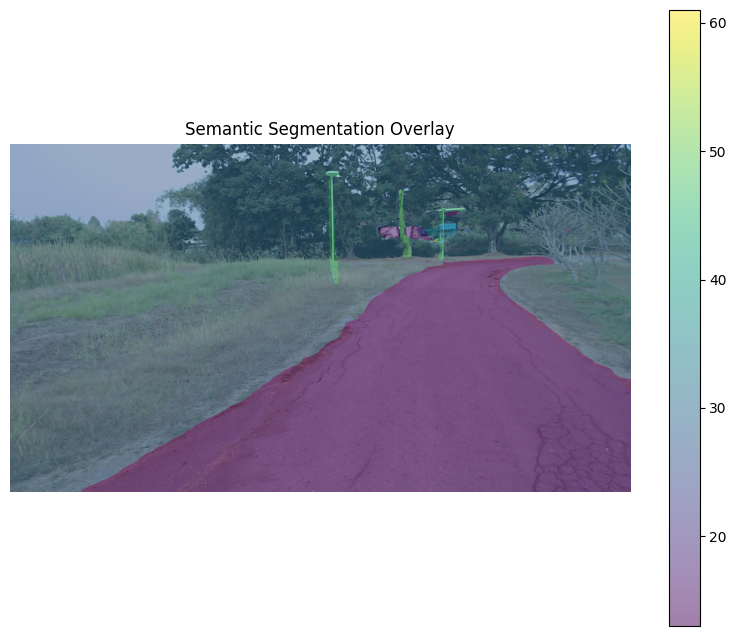

In [39]:
# Load an image from URL
images = [cv2.cvtColor(img1,cv2.COLOR_BGR2RGB),cv2.cvtColor(img2,cv2.COLOR_BGR2RGB)]

# Preprocess the image
inputs = processor(images=images, return_tensors="pt").to(device)

# Perform inference
with torch.no_grad():
    outputs = model(**inputs)

# Post-process to get predicted semantic map
predicted_semantic_map = processor.post_process_semantic_segmentation(outputs, target_sizes=[images[0].shape[:-1]]*len(images))[0]

# Convert predicted semantic map to a numpy array
predicted_semantic_map_np = predicted_semantic_map.cpu().numpy()

# Visualize the original image with overlay of semantic segmentation
plt.figure(figsize=(10, 8))

# Plot the original image
plt.imshow(images[0])
plt.axis('off')

# Overlay the semantic segmentation on the original image
plt.imshow(predicted_semantic_map_np, alpha=0.5, cmap='viridis')  # Adjust alpha for transparency
plt.colorbar()  # Show colorbar for semantic classes

# Add a title
plt.title("Semantic Segmentation Overlay")

# Show the plot
plt.show()


In [20]:
class_queries_logits = outputs.class_queries_logits
masks_queries_logits = outputs.masks_queries_logits

In [33]:
class_queries_logits.shape,masks_queries_logits.shape

(torch.Size([2, 100, 66]), torch.Size([2, 100, 96, 96]))

In [32]:
masks_queries_logits[0].argmax(dim=0).cpu()

tensor([[88, 88, 88,  ..., 98, 98, 98],
        [88, 88, 88,  ..., 98, 98, 98],
        [88, 88, 88,  ..., 98, 98, 98],
        ...,
        [11, 11, 66,  ..., 63, 63, 63],
        [66, 66, 66,  ..., 63, 63, 63],
        [11, 66, 66,  ..., 63, 63, 63]])

In [23]:


a = {
    "0": "road",
    "1": "sidewalk",
    "2": "building",
    "3": "wall",
    "4": "fence",
    "5": "pole",
    "6": "traffic light",
    "7": "traffic sign",
    "8": "vegetation",
    "9": "terrain",
    "10": "sky",
    "11": "person",
    "12": "rider",
    "13": "car",
    "14": "truck",
    "15": "bus",
    "16": "train",
    "17": "motorcycle",
    "18": "bicycle"
  }

b = model.config.label2id

b = {key.lower(): value for key, value in b.items()}

# Create a mapping dictionary based on matching values
mapping_dict = {}

for key1, value1 in a.items():
  if value1 in b.keys():
      mapping_dict[int(b[value1])] = int(key1)  # Convert key2 from string to integer

print(mapping_dict,len(mapping_dict))
mapping_label = {**mapping_dict,49:7,50:7,46:7,20:12,21:12,22:12}

In [28]:
b

{'banner': 32,
 'barrier': 5,
 'bench': 33,
 'bicycle': 52,
 'bicyclist': 20,
 'bike lane': 7,
 'bike rack': 34,
 'billboard': 35,
 'bird': 0,
 'boat': 53,
 'bridge': 16,
 'building': 17,
 'bus': 54,
 'cctv camera': 37,
 'car': 55,
 'car mount': 63,
 'caravan': 56,
 'catch basin': 36,
 'crosswalk - plain': 8,
 'curb': 2,
 'curb cut': 9,
 'ego vehicle': 64,
 'fence': 3,
 'fire hydrant': 38,
 'ground animal': 1,
 'guard rail': 4,
 'junction box': 39,
 'lane marking - crosswalk': 23,
 'lane marking - general': 24,
 'mailbox': 40,
 'manhole': 41,
 'motorcycle': 57,
 'motorcyclist': 21,
 'mountain': 25,
 'on rails': 58,
 'other rider': 22,
 'other vehicle': 59,
 'parking': 10,
 'pedestrian area': 11,
 'person': 19,
 'phone booth': 42,
 'pole': 45,
 'pothole': 43,
 'rail track': 12,
 'road': 13,
 'sand': 26,
 'service lane': 14,
 'sidewalk': 15,
 'sky': 27,
 'snow': 28,
 'street light': 44,
 'terrain': 29,
 'traffic light': 48,
 'traffic sign (back)': 49,
 'traffic sign (front)': 50,
 'traff

In [30]:
# Create a mapping dictionary based on matching values
mapping_dict = {}

for key1, value1 in a.items():
  if value1 in b.keys():
      mapping_dict[int(b[value1])] = int(key1)  # Convert key2 from string to integer

print(mapping_dict,len(mapping_dict))

{13: 0, 15: 1, 17: 2, 6: 3, 3: 4, 45: 5, 48: 6, 30: 8, 29: 9, 27: 10, 19: 11, 55: 13, 61: 14, 54: 15, 57: 17, 52: 18} 16


In [29]:
mapping_label = {**mapping_dict,49:7,50:7,46:7,20:12,21:12,22:12}

{0: 13,
 1: 15,
 2: 17,
 3: 6,
 4: 3,
 5: 45,
 6: 48,
 8: 30,
 9: 29,
 10: 27,
 11: 19,
 13: 55,
 14: 61,
 15: 54,
 17: 57,
 18: 52}

In [15]:
model.config.label2id

{'Banner': 32,
 'Barrier': 5,
 'Bench': 33,
 'Bicycle': 52,
 'Bicyclist': 20,
 'Bike Lane': 7,
 'Bike Rack': 34,
 'Billboard': 35,
 'Bird': 0,
 'Boat': 53,
 'Bridge': 16,
 'Building': 17,
 'Bus': 54,
 'CCTV Camera': 37,
 'Car': 55,
 'Car Mount': 63,
 'Caravan': 56,
 'Catch Basin': 36,
 'Crosswalk - Plain': 8,
 'Curb': 2,
 'Curb Cut': 9,
 'Ego Vehicle': 64,
 'Fence': 3,
 'Fire Hydrant': 38,
 'Ground Animal': 1,
 'Guard Rail': 4,
 'Junction Box': 39,
 'Lane Marking - Crosswalk': 23,
 'Lane Marking - General': 24,
 'Mailbox': 40,
 'Manhole': 41,
 'Motorcycle': 57,
 'Motorcyclist': 21,
 'Mountain': 25,
 'On Rails': 58,
 'Other Rider': 22,
 'Other Vehicle': 59,
 'Parking': 10,
 'Pedestrian Area': 11,
 'Person': 19,
 'Phone Booth': 42,
 'Pole': 45,
 'Pothole': 43,
 'Rail Track': 12,
 'Road': 13,
 'Sand': 26,
 'Service Lane': 14,
 'Sidewalk': 15,
 'Sky': 27,
 'Snow': 28,
 'Street Light': 44,
 'Terrain': 29,
 'Traffic Light': 48,
 'Traffic Sign (Back)': 49,
 'Traffic Sign (Front)': 50,
 'Traff

In [58]:
predicted_semantic_map_np.shape

(1280,)

In [3]:
import requests
import matplotlib.pyplot as plt
from transformers import pipeline
import torch

segmenter = pipeline(
    "image-segmentation",
    model="facebook/mask2former-swin-large-cityscapes-semantic",
    device=0 if torch.cuda.is_available() else -1  # Use GPU if available
)

In [9]:
from PIL import Image
pil_image = Image.fromarray(img1)
results = segmenter(pil_image)

`label_ids_to_fuse` unset. No instance will be fused.


In [10]:
results

[{'score': 0.948429,
  'label': 'sky',
  'mask': <PIL.Image.Image image mode=L size=1280x720>},
 {'score': 0.933613,
  'label': 'building',
  'mask': <PIL.Image.Image image mode=L size=1280x720>},
 {'score': 0.999472,
  'label': 'road',
  'mask': <PIL.Image.Image image mode=L size=1280x720>},
 {'score': 0.999346,
  'label': 'pole',
  'mask': <PIL.Image.Image image mode=L size=1280x720>},
 {'score': 0.999667,
  'label': 'terrain',
  'mask': <PIL.Image.Image image mode=L size=1280x720>},
 {'score': 0.999889,
  'label': 'vegetation',
  'mask': <PIL.Image.Image image mode=L size=1280x720>}]

In [11]:
import numpy as np

masks = [result['mask'] for result in results]
# Convert PIL masks to numpy arrays
masks = [np.array(mask) for mask in masks]


In [13]:
color=sidewalk_palette()

In [24]:
color[0]

[155, 155, 155]

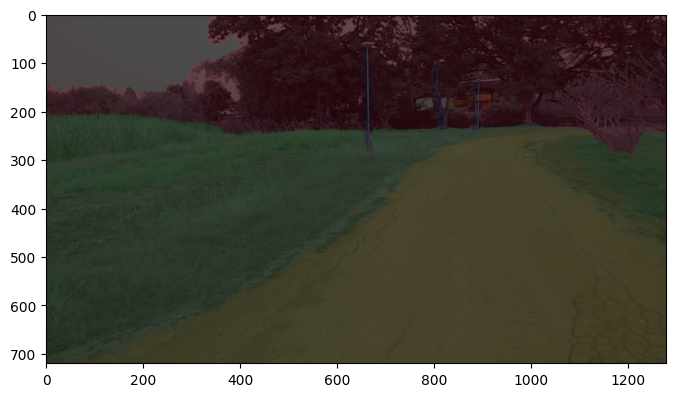

In [16]:
import matplotlib.pyplot as plt

# Display the original image
plt.figure(figsize=(8, 6))
plt.imshow(pil_image)

# Overlay each mask on the image
for i, result in enumerate(results):
    mask = masks[i]
    label = result['label']
    # Create a mask color for each class
    mask_color = np.zeros_like(pil_image)
    mask_color[mask == 255] = color[i] # Assuming RGB image

    # Display the mask overlay
    plt.imshow(mask_color, alpha=0.5)  # Adjust alpha for transparency

    # Show the class label as the plot title
    # plt.title(f"Class: {label}")
    # plt.axis('off')
plt.show()


## onnx

In [29]:
import onnx

# Load the ONNX model
onnx_model = onnx.load('seg/tao_model/pretrained_segformer_cityscapes_deployable_fan_tiny_hybrid_v1.0/cityscapes_fan_tiny_hybrid_224.onnx')



In [32]:
onnx.checker.check_model(onnx_model)

In [31]:
onnx_model.graph.input[0].type.tensor_type.shape.dim[0].dim_value

0

In [ ]:
# Modify the input shape to accept batch size 3
input_shape = [3, 3, 224, 224]  # [batch_size, channels, height, width]
onnx_model.graph.input[0].type.tensor_type.shape.dim[0].dim_value = input_shape[0]

# Save the modified model
onnx.save(onnx_model, '/path/to/modified_model.onnx')


## tensorrt

python3 -m pip install tensorrt-10.0.1-cp38-none-linux_x86_64.whl
python3 -m pip install onnx_graphsurgeon-0.5.0-py2.py3-none-any.whl

/home/lpr/TensorRT-8.6.1.6/bin/trtexec --onnx=cityscapes_fan_tiny_hybrid_224.onnx  --saveEngine=cityscapes_fan_tiny_hybrid_224.onnx_engine.trt

trtexec --onnx=fan-small/cityscapes_fan_small_hybrid_224.onnx  --saveEngine=fan-small/cityscapes_fan_small_hybrid_224_onnx_engine.trt

/home/lpr/TensorRT-8.6.1.6/bin/trtexec \
--onnx=fan-tiny/cityscapes_fan_tiny_hybrid_224.onnx \
--saveEngine=fan-tiny/cityscapes_fan_tiny_hybrid_rangeinput_onnx_engine.trt \
--minShapes=input:1x3x224x224 \
--optShapes=input:4x3x224x224 \
--maxShapes=input:8x3x224x224 \
--shapes=input:3x3x224x224

/home/lpr/TensorRT-8.6.1.6/bin/trtexec \
--onnx=fan-tiny/cityscapes_fan_tiny_hybrid_224.onnx \
--saveEngine=fan-tiny/cityscapes_fan_tiny_hybrid_3x3x224x224_onnx_engine.trt \
--shapes=input:3x3x224x224

/home/lpr/TensorRT-8.6.1.6/bin/trtexec \
--onnx=fan-base/cityscapes_fan_base_hybrid_224.onnx \
--saveEngine=fan-base/cityscapes_fan_base_hybrid_224_engine.trt

/home/lpr/TensorRT-10.0.1.6/bin/trtexec \
--onnx=citysem-fan/citysemsegformer_fan.onnx \
--saveEngine=citysem-fan/citysemsegformer_fan_v10.trt

/home/lpr/TensorRT-10.0.1.6/bin/trtexec \
--onnx=fan-base/cityscapes_fan_base_hybrid_224.onnx \
--saveEngine=fan-base/cityscapes_fan_base_hybrid_224.trt



In [ ]:
trtexec --onnx=citysem-fan/citysemsegformer_fan.onnx --fp16 --verbose --profilingVerbosity=detailed --dumpLayerInfo --dumpProfile --separateProfileRun --useCudaGraph --noDataTransfers --useSpinWait --duration=60

export LD_LIBRARY_PATH=/home/lpr/miniconda3/envs/CarlaEnv/lib/python3.8/site-packages/tensorrt/lib
export LD_LIBRARY_PATH=/home/lpr/miniconda3/envs/AutoCar/lib/python3.8/site-packages/tensorrt/lib
export LD_LIBRARY_PATH=/home/lpr/miniconda3/envs/AutoCar/lib/python3.8/site-packages/tensorrt/lib
export LD_LIBRARY_PATH=$LD_LIBRARY_PATH:/usr/local/cuda-x.x/lib64:/path/to/TensorRT-8.x.x/lib

export LD_LIBRARY_PATH=$LD_LIBRARY_PATH:/home/lpr/TensorRT-10.0.1.6/lib
export PATH=$PATH:/home/lpr/TensorRT-10.0.1.6/bin

export PATH=$PATH:<your tensorrt extracted folder>/bin

In [1]:

import os

# export LD_LIBRARY_PATH=$LD_LIBRARY_PATH:/home/lpr/TensorRT-10.0.1.6/lib
# export PATH=$PATH:/home/lpr/TensorRT-10.0.1.6/bin

# os.environ['LD_LIBRARY_PATH'] = '/home/lpr/TensorRT-10.0.1.6/targets/x86_64-linux-gnu/lib:$LD_LIBRARY_PATH'
# os.environ['PATH'] = '$PATH:/home/lpr/TensorRT-10.0.1.6/bin'
import tensorrt as trt

print(trt.__version__)
print(trt.__path__)

8.6.0
['/home/lpr/miniconda3/envs/CarlaEnv/lib/python3.8/site-packages/tensorrt']


In [ ]:
/home/lpr/TensorRT-10.0.1.6/lib

In [ ]:
# from optimum.onnxruntime import ORTModelForSequenceClassification
# from transformers import AutoTokenizer

# ort_model = ORTModelForSequenceClassification.from_pretrained(
#     "philschmid/tiny-bert-sst2-distilled",
#     export=True,
#     provider="TensorrtExecutionProvider",
# )

# tokenizer = AutoTokenizer.from_pretrained("philschmid/tiny-bert-sst2-distilled")
# inp = tokenizer("expectations were low, actual enjoyment was high", return_tensors="pt", padding=True)

# result = ort_model(**inp)
# assert ort_model.providers == ["TensorrtExecutionProvider", "CUDAExecutionProvider", "CPUExecutionProvider"]

segformer-cityscape   
net-scale-factor=0.01735207357279195  
offsets=123.675;116.28;103.53  
    y = net scale factor*(x-mean) 

mean = offsets[c] 


In [2]:
from seg.seg_utils import segFormerTRT
# the full code are in module i wrote

# for range input => seg/tao_model/fan-tiny/cityscapes_fan_tiny_hybrid_rangeinput_onnx_engine.trt
# for batch=1 => seg/tao_model/fan-tiny/cityscapes_fan_tiny_hybrid_224.onnx_engine.trt
# for batch=3 => seg/tao_model/fan-tiny/cityscapes_fan_tiny_hybrid_3x3x224x224_onnx_engine.trt
trt_model = segFormerTRT('seg/tao_model/fan-tiny/cityscapes_fan_tiny_hybrid_224.onnx_engine.trt')

TensorRT version: 8.6.0
Reading engine from file seg/tao_model/fan-tiny/cityscapes_fan_tiny_hybrid_224.onnx_engine.trt
using default preprocessor for nvidia segformer pretrained cityscape


In [3]:
import cv2

img1 = cv2.imread("data/raw_4cams/front/263.jpg")
img2 = cv2.imread("data/raw_4cams/left/1380.jpg")
img3 = cv2.imread("data/raw_4cams/right/1000.jpg")

In [4]:
inputs = [img1]
preds = trt_model.predict(inputs)
overlayed = trt_model.get_seg_overlay(inputs,preds)


In [29]:
overlayed[0].shape

(720, 1280, 3)

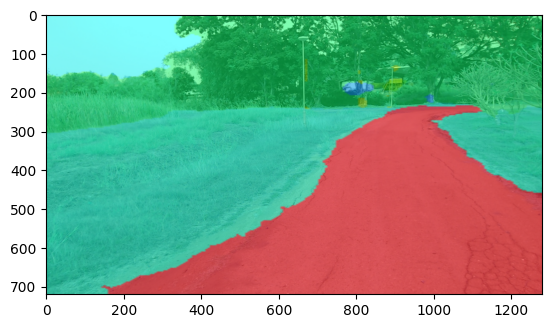

In [5]:
import matplotlib.pyplot as plt
plt.imshow(overlayed[0])

test with controller

In [33]:
def trt_overlayed(img,crop_box):
    y1,y2, x1,x2 = crop_box
    img1 = img[y1:y2,x1:x2]

    inputs = [img1]
    preds = trt_model.predict(inputs)
    overlayed = trt_model.get_seg_overlay(inputs,preds)

    return overlayed

    

In [17]:
img1.shape

(720, 1280, 3)

In [ ]:
from my_tools.control import ImageController

In [36]:
from my_tools.control import ImageController

controller = ImageController(process=trt_overlayed)

In [37]:
controller.run()

### after this is some experiment

In [12]:
preprocessed_image = trt_model.preprocess(img2)

In [51]:
rand =np.random.rand(*(3,3,224,224))

In [95]:
import colorsys
def generate_colors(num_classes):
    hsv_colors = [(i / num_classes, 1.0 if i % 2 == 0 else 0.7, 1.0 if i % 3 == 0 else 0.7) for i in range(num_classes)]
    rgb_colors = [colorsys.hsv_to_rgb(*color) for color in hsv_colors]
    rgb_colors = [(int(r * 255), int(g * 255), int(b * 255)) for (r, g, b) in rgb_colors]
    return np.array(rgb_colors).astype(np.uint8)

num_classes = 20  # Number of classes

# Generate colors for each class
color_array = generate_colors(num_classes)

colors_rgb = color_array

# Normalize RGB values to range [0, 1]
colors_rgb_normalized = colors_rgb / 255.0

# Create a figure and plot the colors
fig, ax = plt.subplots(figsize=(10, 1))  # Adjust the figure size as needed
for i, (r, g, b) in  enumerate(colors_rgb_normalized):
    ax.add_patch(plt.Rectangle((i, 0), 1, 1, color=(r, g, b)))

# Set x-axis limits and hide y-axis
ax.set_xlim(0, len(color_array))
ax.set_ylim(0, 1)
ax.axis('off')

# Show the plot
plt.show()

In [42]:
original_list = (1, 2, 3, 4)
sliced_list = original_list[::2]
print(sliced_list)  # Output: (1, 3, 4)


(1, 3)


In [5]:
preprocessed_images=[]
for img in [img1,img2,img3]:

    input_width, input_height = 224,224
    resized_image = cv2.resize(img, (input_width, input_height))
    resized_image = cv2.cvtColor(resized_image, cv2.COLOR_BGR2RGB)

    # Convert the image to float32 and apply color format adjustment
    resized_image = resized_image.astype(np.float32)
    resized_image -= np.array([123.675, 116.28, 103.53])

    # Scale the image data by the net-scale-factor
    net_scale_factor = 0.01735207357279195
    resized_image *= net_scale_factor

    # Expand dimensions to match the model input shape (3, 1024, 1024)
    preprocessed_image = np.transpose(resized_image, (2, 0, 1))  # (H, W, C) to (C, H, W)
    # preprocessed_image = np.expand_dims(preprocessed_image, axis=0)  # Add batch dimension

    preprocessed_images.append(preprocessed_image)

    # Convert the preprocessed image to a format suitable for inference (e.g., to Tensor)
    # preprocessed_image = np.ascontiguousarray(preprocessed_image)

In [33]:
np.stack([img1],axis=0).shape

(1, 720, 1280, 3)

In [7]:
stack_image = np.stack(preprocessed_images,axis=0)
stack_image.shape

(3, 3, 224, 224)

# Compare everything

In [1]:
import cv2
import matplotlib.pyplot as plt
import numpy as np
import torch
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

img1 = cv2.imread("data/raw_4cams/front/263.jpg")
img2 = cv2.imread("data/raw_4cams/front/1380.jpg")
img3 = cv2.imread("data/raw_4cams/front/1820.jpg")

controller

In [2]:
from my_tools.control import ImageController
controller = ImageController(add_trackbar={"resize_x":(212,1280),"resize_y":(212,720)})

no function apply using default function


## tensorrt

In [3]:
from seg.seg_utils import segFormerTRT
# the full code are in module i wrote

/home/lpr/miniconda3/envs/CarlaEnv/lib/python3.8/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [4]:
import sys
print(sys.path)

['/home/lpr/project_nattabude/carla/self-driving-sb3', '/home/lpr/miniconda3/envs/CarlaEnv/lib/python38.zip', '/home/lpr/miniconda3/envs/CarlaEnv/lib/python3.8', '/home/lpr/miniconda3/envs/CarlaEnv/lib/python3.8/lib-dynload', '', '/home/lpr/miniconda3/envs/CarlaEnv/lib/python3.8/site-packages', '/tmp/tmpryzwadr5']


In [5]:


# modelrepo = 'seg/tao_model/fan-tiny/cityscapes_fan_tiny_hybrid_rangeinput_onnx_engine.trt' # for range input 
# modelrepo = 'seg/tao_model/fan-tiny/cityscapes_fan_tiny_hybrid_224.onnx_engine.trt' # for batch=1 
# modelrepo = 'seg/tao_model/fan-tiny/cityscapes_fan_tiny_hybrid_3x3x224x224_onnx_engine.trt' # for batch=3

# modelrepo =  'seg/tao_model/fan-small/cityscapes_fan_small_hybrid_224_onnx_engine.trt'

# modelrepo = 'seg/tao_model/fan-base/cityscapes_fan_base_hybrid_224_engine.trt'

modelrepo = 'seg/tao_model/citysem-fan/citysemsegformer_fan_fp16.trt'

trt_model = segFormerTRT(modelrepo)


TensorRT version: 8.6.0
Reading engine from file seg/tao_model/citysem-fan/citysemsegformer_fan_fp16.trt
inference time :0.10


In [9]:
mapping = {0:0,11:1,12:1,13:2,14:2,15:2,17:1,18:1}
trt_model.apply_label_mapping(mapping)

In [10]:
def trt_overlayed(img,crop_box):
    y1,y2, x1,x2 = crop_box
    img1 = img[y1:y2,x1:x2]
    #=========
    inputs = [img1]
    preds = trt_model.predict(inputs)
    overlayed = trt_model.get_seg_overlay(inputs,preds)

    return overlayed

controller.process = trt_overlayed

In [11]:
controller.run()

## hugging face 

### segformer

In [3]:
from seg.seg_utils import HF_segFormermodel

# model_repo = "nvidia/segformer-b0-finetuned-cityscapes-768-768"
model_repo = "nvidia/segformer-b0-finetuned-cityscapes-512-1024"
# model_repo = "nvidia/segformer-b0-finetuned-cityscapes-640-1280"
# model_repo = "nvidia/segformer-b1-finetuned-cityscapes-1024-1024"


# seg_model = HF_segFormermodel(model_repo,custom_processor=custom_process)
seg_model = HF_segFormermodel(model_repo)

/home/lpr/miniconda3/envs/AutoCar/lib/python3.8/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


using  cuda


/home/lpr/miniconda3/envs/AutoCar/lib/python3.8/site-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
/home/lpr/miniconda3/envs/AutoCar/lib/python3.8/site-packages/transformers/models/segformer/image_processing_segformer.py:103: FutureWarning: The `reduce_labels` parameter is deprecated and will be removed in a future version. Please use `do_reduce_labels` instead.
  warnings.warn(


inference time :0.02


In [13]:
seg_model.model.config.id2label

{0: 'road',
 1: 'sidewalk',
 2: 'building',
 3: 'wall',
 4: 'fence',
 5: 'pole',
 6: 'traffic light',
 7: 'traffic sign',
 8: 'vegetation',
 9: 'terrain',
 10: 'sky',
 11: 'person',
 12: 'rider',
 13: 'car',
 14: 'truck',
 15: 'bus',
 16: 'train',
 17: 'motorcycle',
 18: 'bicycle'}

In [14]:
mapping = {0:0,11:1,12:1,13:2,14:2,15:2,17:1,18:1}
seg_model.apply_label_mapping(mapping)

In [15]:

def seg_wraper(img,crop_box):
    y1,y2, x1,x2 = crop_box
    img = img[y1:y2, x1:x2]
    img = cv2.cvtColor(img,cv2.COLOR_BGR2RGB)

    #======
    preds, _ = seg_model.predict([img],upsampling=True)
    overlays = seg_model.get_seg_overlay([img],preds) 
    return overlays

# controller.apply_processor(seg_wraper)
controller.process = seg_wraper

In [16]:
controller.run()

### mask2former

In [3]:
from seg.seg_utils import HF_mask2Formermodel


model_repo = "facebook/mask2former-swin-large-mapillary-vistas-semantic"
# model_repo = "facebook/mask2former-swin-large-cityscapes-semantic"


# seg_model = HF_segFormermodel(model_repo,custom_processor=custom_process)
seg_model = HF_mask2Formermodel(model_repo)


/home/lpr/miniconda3/envs/CarlaEnv/lib/python3.8/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


using  cuda
inference time :0.08


In [2]:
seg_model.model.config.id2label

{0: 'Bird',
 1: 'Ground Animal',
 2: 'Curb',
 3: 'Fence',
 4: 'Guard Rail',
 5: 'Barrier',
 6: 'Wall',
 7: 'Bike Lane',
 8: 'Crosswalk - Plain',
 9: 'Curb Cut',
 10: 'Parking',
 11: 'Pedestrian Area',
 12: 'Rail Track',
 13: 'Road',
 14: 'Service Lane',
 15: 'Sidewalk',
 16: 'Bridge',
 17: 'Building',
 18: 'Tunnel',
 19: 'Person',
 20: 'Bicyclist',
 21: 'Motorcyclist',
 22: 'Other Rider',
 23: 'Lane Marking - Crosswalk',
 24: 'Lane Marking - General',
 25: 'Mountain',
 26: 'Sand',
 27: 'Sky',
 28: 'Snow',
 29: 'Terrain',
 30: 'Vegetation',
 31: 'Water',
 32: 'Banner',
 33: 'Bench',
 34: 'Bike Rack',
 35: 'Billboard',
 36: 'Catch Basin',
 37: 'CCTV Camera',
 38: 'Fire Hydrant',
 39: 'Junction Box',
 40: 'Mailbox',
 41: 'Manhole',
 42: 'Phone Booth',
 43: 'Pothole',
 44: 'Street Light',
 45: 'Pole',
 46: 'Traffic Sign Frame',
 47: 'Utility Pole',
 48: 'Traffic Light',
 49: 'Traffic Sign (Back)',
 50: 'Traffic Sign (Front)',
 51: 'Trash Can',
 52: 'Bicycle',
 53: 'Boat',
 54: 'Bus',
 55: 

In [4]:
# mapping = {0:0,11:1,12:1,13:2,14:2,15:2,17:1,18:1}
mapping = {13:1,7:1,23:2,24:2,52:3,55:3,57:3,20:4,21:4,22:4,19:4} # 0 is back ground
seg_model.apply_label_mapping(mapping)

In [6]:
seg_model.apply_label_mapping(None)

In [8]:

def seg_wraper(**arg):
    y1,y2, x1,x2 = arg['crop_box']
    img = arg['img'][y1:y2, x1:x2]
    resize_x,resize_y = arg['resize_x'],arg['resize_y']
    img = cv2.cvtColor(img,cv2.COLOR_BGR2RGB)
    img = cv2.resize(img,(resize_x,resize_y))
    #======
    preds, _ = seg_model.predict([img])
    overlays = seg_model.get_seg_overlay([img],preds) 
    overlays = [cv2.cvtColor(img,cv2.COLOR_RGB2BGR) for img in overlays]

    # overlays = seg_model.get_seg_images(preds) 
    return overlays

# controller.apply_processor(seg_wraper)
controller.process = seg_wraper

In [9]:
controller.run()

## create dataset

In [10]:
from PIL import Image
import os

def combine_images(folder_paths, output_folder):
    image_count = {}

    if not os.path.exists(output_folder):
        os.makedirs(output_folder)
    
    for folder_path in folder_paths:
        for filename in os.listdir(folder_path):
            if filename.endswith(('.png', '.jpg', '.jpeg')):  # Filter only image files
                filepath = os.path.join(folder_path, filename)
                image = Image.open(filepath)

                # Generate unique filename if there's a naming conflict
                if filename in image_count:
                    image_count[filename] += 1
                    new_filename = f"{os.path.splitext(filename)[0]}_{image_count[filename]}{os.path.splitext(filename)[1]}"
                else:
                    image_count[filename] = 0
                    new_filename = filename

                output_path = os.path.join(output_folder, new_filename)
                image.save(output_path)
                print(f"Saved: {output_path}")

if __name__ == "__main__":
    folder_paths = ["data/experiments/2024-03-21_11-15-16/cam2", 
                    "data/experiments/2024-03-21_11-16-10/cam2",
                      "data/experiments/2024-03-21_11-36-33/cam2",
                      "data/experiments/2024-03-21_11-41-49/cam2",
                      "data/experiments/2024-03-21_11-52-00/cam2"]  # Paths to your image folders
    output_folder = "data/cam640"  # Output folder where combined images will be saved

    if not os.path.exists(output_folder):
        os.makedirs(output_folder)

    combine_images(folder_paths, output_folder)


Saved: data/cam640/1.png
Saved: data/cam640/2.png
Saved: data/cam640/16.png
Saved: data/cam640/10.png
Saved: data/cam640/3.png
Saved: data/cam640/6.png
Saved: data/cam640/7.png
Saved: data/cam640/12.png
Saved: data/cam640/14.png
Saved: data/cam640/17.png
Saved: data/cam640/11.png
Saved: data/cam640/8.png
Saved: data/cam640/9.png
Saved: data/cam640/13.png
Saved: data/cam640/15.png
Saved: data/cam640/5.png
Saved: data/cam640/4.png
Saved: data/cam640/53.png
Saved: data/cam640/74.png
Saved: data/cam640/66.png
Saved: data/cam640/1_1.png
Saved: data/cam640/2_1.png
Saved: data/cam640/16_1.png
Saved: data/cam640/58.png
Saved: data/cam640/76.png
Saved: data/cam640/70.png
Saved: data/cam640/18.png
Saved: data/cam640/67.png
Saved: data/cam640/63.png
Saved: data/cam640/40.png
Saved: data/cam640/32.png
Saved: data/cam640/10_1.png
Saved: data/cam640/75.png
Saved: data/cam640/62.png
Saved: data/cam640/36.png
Saved: data/cam640/47.png
Saved: data/cam640/57.png
Saved: data/cam640/69.png
Saved: data/cam

In [22]:
seg_images = seg_model.get_seg_images([preds[0]])

cv2.imshow("test",seg_images[0])
cv2.waitKey(0)
cv2.destroyAllWindows()

In [3]:
import os
import cv2
from PIL import Image
input_folder = "data/cam640"
output_folder = "data/seg_maps/mask2former2"
def create_dataset(input_folder,
                   output_folder,
                   seg_model,
                   crop_box,
                   batch_size = 16):
    all_imgs=os.listdir(input_folder)
    w,h = 1024,512
    shape = cv2.imread(os.path.join(input_folder,all_imgs[0])).shape
    y1,y2, x1,x2 = int(shape[0]/2-h/2), int(shape[0]/2+h/2), int(shape[1]/2-w/2), int(shape[1]/2+w/2)
    if not os.path.exists(output_folder):
        os.makedirs(output_folder)

    all_imgs=os.listdir(input_folder)
    for i in range(0,len(all_imgs),batch_size):
        imgs_name = all_imgs[i:i+batch_size]
        imgs =[cv2.cvtColor(cv2.imread(os.path.join(input_folder,imgname))[y1:y2,x1:x2],cv2.COLOR_BGR2RGB) for imgname in imgs_name]
        preds,_ = seg_model.predict(imgs)
        for j,imgname in enumerate(imgs_name):
            image = Image.fromarray(preds[j])
            image.save(os.path.join(output_folder,imgname.rsplit('.',1)[0]+"_cam640"+'.png'))

In [ ]:
preds[0]

In [3]:
from my_tools.control import ImageController
controllor2 = ImageController(folder = 'data/seg_maps',box=(512, 256, 1024, 512))

no function apply using default function


In [22]:
import cv2
def viseg(**arg):
    y1,y2,x1,x2 = arg['crop_box']
    img = cv2.cvtColor(arg['img'],cv2.COLOR_BGR2GRAY)
    seg_image = seg_model.get_seg_images([img])[0][y1:y2,x1:x2]

    return [seg_image]
    



In [23]:
controllor2.apply_processor(viseg)

In [24]:
controllor2.run()

In [16]:
seg_map = cv2.imread("data/seg_maps/mask2former/264.png", cv2.IMREAD_GRAYSCALE)

seg_images = seg_model.get_seg_images([seg_map])

cv2.imshow("test",seg_images[0])
cv2.waitKey(0)
cv2.destroyAllWindows()

In [40]:
import numpy as np
seg_map = cv2.imread("data/seg_maps/mask2former/3147.png")
np.unique(seg_map)

array([0, 1, 2, 3, 4], dtype=uint8)

In [39]:
seg_map[5]

array([0, 0, 0, ..., 0, 0, 0], dtype=uint8)